## Load Train + Test

In [ ]:
import pandas as pd

trainingSet = r"c:\Users\Matt\Desktop\CS506\midterm2\test.csv"
testingSet = r"c:\Users\Matt\Desktop\CS506\midterm2\train.csv"

trainingSet = pd.read_csv(trainingSet)
testingSet = pd.read_csv(testingSet)

print(f"Train shape: {trainingSet.shape}")
print(f"Test shape: {testingSet.shape}")
print("\nTrain columns:", trainingSet.columns.tolist())
print("\nFirst few rows of train:")

testingSet.head()


## Extract Features from Train

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import re
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load the training and test data
trainingSet = r"c:\Users\Matt\Desktop\CS506\midterm2\test.csv"
testingSet = r"c:\Users\Matt\Desktop\CS506\midterm2\train.csv"

trainingSet = pd.read_csv(trainingSet)
testingSet = pd.read_csv(testingSet)

print(f"Training set shape: {trainingSet.shape}")
print(f"Test set shape: {testingSet.shape}")

# Create a copy for feature engineering (using sampled data)
dataset = testingSet.copy()

# --- Fix: normalize column names used later in the notebook ---
# Map common alternate column names to the expected names used by the feature engineering code
col_map = {}
if 'Text' in dataset.columns:
    col_map['Text'] = 'reviewText'
if 'Summary' in dataset.columns:
    col_map['Summary'] = 'summary'
if 'UserId' in dataset.columns:
    col_map['UserId'] = 'reviewerID'
if 'ProductId' in dataset.columns:
    col_map['ProductId'] = 'album_mbid'
if 'Id' in dataset.columns:
    col_map['Id'] = 'id'

if col_map:
    dataset = dataset.rename(columns=col_map)

# Ensure any columns referenced later exist; if missing, create with safe defaults
required_defaults = {
    'genres': '',
    'artist_mbid': '',
    'unixReviewTime': 0,   # will convert to 1970-01-01 if missing
    'VotedHelpful': 0,
    'TotalVotes': 0,
    'Score': np.nan
}
for col, default in required_defaults.items():
    if col not in dataset.columns:
        dataset[col] = default

# Feature 1: Text-based features
print("Extracting text features...")
dataset['reviewText_length'] = dataset['reviewText'].fillna('').astype(str).str.len()
dataset['summary_length'] = dataset['summary'].fillna('').astype(str).str.len()
dataset['summary_word_count'] = dataset['summary'].fillna('').astype(str).str.split().str.len()
dataset['reviewText_word_count'] = dataset['reviewText'].fillna('').astype(str).str.split().str.len()

# Feature 2: Helpfulness features
dataset['helpfulness_ratio'] = dataset['VotedHelpful'] / (dataset['TotalVotes'] + 1)  # +1 to avoid division by zero
dataset['has_votes'] = (dataset['TotalVotes'] > 0).astype(int)

# Feature 3: Time-based features (convert Unix timestamp to datetime)
# If unixReviewTime is not realistic, this will produce 1970-01-01 for zeros - that's safe.
dataset['review_date'] = pd.to_datetime(dataset['unixReviewTime'], unit='s', errors='coerce')
dataset['review_year'] = dataset['review_date'].dt.year.fillna(0).astype(int)
dataset['review_month'] = dataset['review_date'].dt.month.fillna(0).astype(int)
dataset['review_day_of_week'] = dataset['review_date'].dt.dayofweek.fillna(0).astype(int)

# Feature 4: Genre features
dataset['num_genres'] = dataset['genres'].fillna('').astype(str).str.split(',').str.len()
dataset['genres'] = dataset['genres'].fillna('')

# Feature 5: Reviewer activity (number of reviews per reviewer)
reviewer_col = 'reviewerID' if 'reviewerID' in dataset.columns else 'reviewerID'  # kept for clarity
reviewer_counts = dataset[reviewer_col].value_counts()
dataset['reviewer_review_count'] = dataset[reviewer_col].map(reviewer_counts).fillna(0).astype(int)

# Feature 6: Album activity (number of reviews per album)
album_counts = dataset['album_mbid'].value_counts()
dataset['album_review_count'] = dataset['album_mbid'].map(album_counts).fillna(0).astype(int)

# Feature 7: Artist activity (number of reviews per artist)
artist_counts = dataset['artist_mbid'].value_counts()
dataset['artist_review_count'] = dataset['artist_mbid'].map(artist_counts).fillna(0).astype(int)

# Feature 8: Review sentiment indicators (simple word-based)
positive_words = ['great', 'love', 'excellent', 'amazing', 'fantastic', 'wonderful', 'best', 'good', 'awesome']
negative_words = ['bad', 'terrible', 'awful', 'horrible', 'worst', 'hate', 'disappointed', 'poor']

dataset['reviewText_lower'] = dataset['reviewText'].fillna('').astype(str).str.lower()
dataset['positive_word_count'] = dataset['reviewText_lower'].apply(
    lambda x: sum(1 for word in positive_words if word in x)
)
dataset['negative_word_count'] = dataset['reviewText_lower'].apply(
    lambda x: sum(1 for word in negative_words if word in x)
)
dataset['sentiment_score'] = dataset['positive_word_count'] - dataset['negative_word_count']

# Feature 9: Exclamation and question marks (engagement indicators)
dataset['exclamation_count'] = dataset['reviewText'].fillna('').astype(str).str.count('!')
dataset['question_count'] = dataset['reviewText'].fillna('').astype(str).str.count(r'\?')  # Escape ? for regex

# Feature 10: Capitalization ratio (possibly indicates enthusiasm)
dataset['caps_ratio'] = dataset['reviewText'].fillna('').astype(str).apply(
    lambda x: sum(1 for c in x if c.isupper()) / (len(x) + 1)
)

# Feature 11: Log transformations for highly skewed features
# These features typically have most values near zero with a long tail
# Log transform helps reveal relationships and makes distributions more normal
print("Adding log-transformed features for skewed distributions...")

# Text length features (log transform)
dataset['reviewText_length_log'] = np.log1p(dataset['reviewText_length'])
dataset['summary_length_log'] = np.log1p(dataset['summary_length'])
dataset['reviewText_word_count_log'] = np.log1p(dataset['reviewText_word_count'])
dataset['summary_word_count_log'] = np.log1p(dataset['summary_word_count'])

# Count features (highly skewed)
dataset['exclamation_count_log'] = np.log1p(dataset['exclamation_count'])
dataset['question_count_log'] = np.log1p(dataset['question_count'])
dataset['positive_word_count_log'] = np.log1p(dataset['positive_word_count'])
dataset['negative_word_count_log'] = np.log1p(dataset['negative_word_count'])

# Vote features (highly skewed - most reviews have 0 votes)
dataset['VotedHelpful_log'] = np.log1p(dataset['VotedHelpful'])
dataset['TotalVotes_log'] = np.log1p(dataset['TotalVotes'])

# Activity features (highly skewed - most entities appear once)
dataset['reviewer_review_count_log'] = np.log1p(dataset['reviewer_review_count'])
dataset['album_review_count_log'] = np.log1p(dataset['album_review_count'])
dataset['artist_review_count_log'] = np.log1p(dataset['artist_review_count'])

print("Log transformations complete!")

# Drop non-numeric columns that won't be used in the model
columns_to_drop = ['id', 'reviewerID', 'album_mbid', 'artist_mbid', 
                   'unixReviewTime', 'summary', 'reviewText', 'genres', 
                   'review_date', 'reviewText_lower']

# Also remove Score temporarily for feature selection
X_features = dataset.drop(columns_to_drop + ['Score'], axis=1, errors='ignore')

# Fill any remaining NaN values
X_features = X_features.fillna(0)

# Create the full dataset with features
# ensure 'id' exists for alignment; if not present, create an index-based id
if 'id' not in dataset.columns:
    dataset['id'] = np.arange(len(dataset))
dataset_features = dataset[['id', 'Score']].copy()
dataset_features = pd.concat([dataset_features, X_features], axis=1)

print(f"\nFeature extraction complete!")
print(f"Number of features created: {len(X_features.columns)}")
print(f"Feature names: {list(X_features.columns)}")

# Display summary
print("\nDataset shape:", dataset_features.shape)
print("\nFirst few rows of features:")
print(dataset_features.head())

# Make sure reviewer_counts, album_counts, artist_counts are saved for later use in test prediction
# These will be used when processing test data

In [ ]:
# Convert train_df and test_df to parquet
train_df = dataset_features.to_parquet(r"c:\Users\Matt\Desktop\CS506\midterm2\train.parquet", index=False)
test_df.to_parquet(r"c:\Users\Matt\Desktop\CS506\midterm2\test.parquet", index=False)

print("Parquet files created successfully!")
print("- train.parquet")
print("- test.parquet")


## Vader for Sentiment Intensity

In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.utils import resample
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download VADER lexicon if not already present
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Load datasets
train_full = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_full = train_full.rename(columns={'Id': 'id', 'ProductId': 'album_mbid', 'UserId': 'reviewerID', 'Summary': 'summary', 'Text': 'reviewText'})
test_df = test_df.rename(columns={'Id': 'id'})

# Drop rows with missing Score
train_full_valid = train_full.dropna(subset=['Score'])

# Split into train and validation sets
train_data, val_data = train_test_split(
    train_full_valid,
    test_size=0.2,
    random_state=42,
    stratify=train_full_valid['Score']
)

# Separate majority and minority classes
df_majority = train_data[train_data['Score'] == 5]
df_minority = train_data[train_data['Score'] < 5]

# Set target sizes for resampling
majority_target = int(df_majority.shape[0] * 0.8)
minority_target = int(df_majority.shape[0] * 0.9)

# Downsample majority class
df_majority_down = resample(df_majority, replace=False, n_samples=majority_target, random_state=42)

# Upsample minority classes
upsampled_minority = []
for cls in [1, 2, 3, 4]:
    df_cls = df_minority[df_minority['Score'] == cls]
    if len(df_cls) == 0:
        continue
    df_upsampled = resample(df_cls, replace=True, n_samples=minority_target, random_state=42)
    upsampled_minority.append(df_upsampled)

# Combine and shuffle to create balanced training set
train_balanced = pd.concat([df_majority_down] + upsampled_minority).sample(frac=1, random_state=42).reset_index(drop=True)

## Fit Features

train_balanced = safe_add_vader(train_balanced)
val_data = safe_add_vader(val_data)

## Write Pickles

In [ ]:
# TODO: WRITE PICKLES FOR ALL VARIABLES
# Save all key variables as pickles in the artifacts directory
import os
os.makedirs('artifacts2', exist_ok=True)
with open('artifacts2/train_balanced.pkl', 'wb') as f:
    pickle.dump(train_balanced, f)
with open('artifacts2/val_data.pkl', 'wb') as f:
    pickle.dump(val_data, f)
with open('artifacts2/train_full.pkl', 'wb') as f:
    pickle.dump(train_full, f)
with open('artifacts2/test_ids.pkl', 'wb') as f:
    pickle.dump(test_ids, f)
with open('artifacts2/feature_cols.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)
with open('artifacts2/df_majority_down.pkl', 'wb') as f:
    pickle.dump(df_majority_down, f)
with open('artifacts2/upsampled_minority.pkl', 'wb') as f:
    pickle.dump(upsampled_minority, f)

## Open Pickles + Parquets

In [45]:
# TODO: OPEN PICKLES FOR ALL VARIABLES

# Load all key variables from pickles in the artifacts directory
import pickle
with open('artifacts2/train_balanced.pkl', 'rb') as f:
    train_balanced = pickle.load(f)
with open('artifacts2/val_data.pkl', 'rb') as f:
    val_data = pickle.load(f)
with open('artifacts2/train_full.pkl', 'rb') as f:
    train_full = pickle.load(f)
with open('artifacts2/test_ids.pkl', 'rb') as f:
    test_ids = pickle.load(f)
with open('artifacts2/feature_cols.pkl', 'rb') as f:
    feature_cols = pickle.load(f)
with open('artifacts2/df_majority_down.pkl', 'rb') as f:
    df_majority_down = pickle.load(f)
with open('artifacts2/upsampled_minority.pkl', 'rb') as f:
    upsampled_minority = pickle.load(f)

In [46]:
import pandas as pd

# Read train.parquet and test.parquet into DataFrames
train_df = pd.read_parquet(r"c:\Users\Matt\Desktop\CS506\midterm2\train.parquet")
test_df = pd.read_parquet(r"c:\Users\Matt\Desktop\CS506\midterm2\test.parquet")

print("Parquet files loaded successfully!")
print("train_df shape:", train_df.shape)
print("test_df shape:", test_df.shape)


Parquet files loaded successfully!
train_df shape: (1697533, 45)
test_df shape: (212192, 2)


## LOG REG

## Join Data

In [47]:
print(train_df.columns)
print(train_balanced.columns)

Index(['id', 'album_mbid', 'reviewerID', 'summary', 'reviewText', 'Score',
       'genres', 'artist_mbid', 'unixReviewTime', 'VotedHelpful', 'TotalVotes',
       'reviewText_length', 'summary_length', 'summary_word_count',
       'reviewText_word_count', 'helpfulness_ratio', 'has_votes',
       'review_date', 'review_year', 'review_month', 'review_day_of_week',
       'num_genres', 'reviewer_review_count', 'album_review_count',
       'artist_review_count', 'reviewText_lower', 'positive_word_count',
       'negative_word_count', 'sentiment_score', 'exclamation_count',
       'question_count', 'caps_ratio', 'reviewText_length_log',
       'summary_length_log', 'reviewText_word_count_log',
       'summary_word_count_log', 'exclamation_count_log', 'question_count_log',
       'positive_word_count_log', 'negative_word_count_log',
       'VotedHelpful_log', 'TotalVotes_log', 'reviewer_review_count_log',
       'album_review_count_log', 'artist_review_count_log'],
      dtype='object')
Index

In [48]:

# Perform a left join on train_balanced and train_df using 'id' as the key
joined_df = train_balanced.merge(train_df, how='left', on='id', suffixes=('_balanced', '_train'))

# Check the shape of the resulting DataFrame
print("Joined shape:", joined_df.shape)

# Drop rows where Score_train is NA in joined_df
joined_df = joined_df[joined_df['Score_train'].notna()].copy()
print("Rows after dropping NA Score_train:", len(joined_df))

Joined shape: (2791932, 52)
Rows after dropping NA Score_train: 2791932


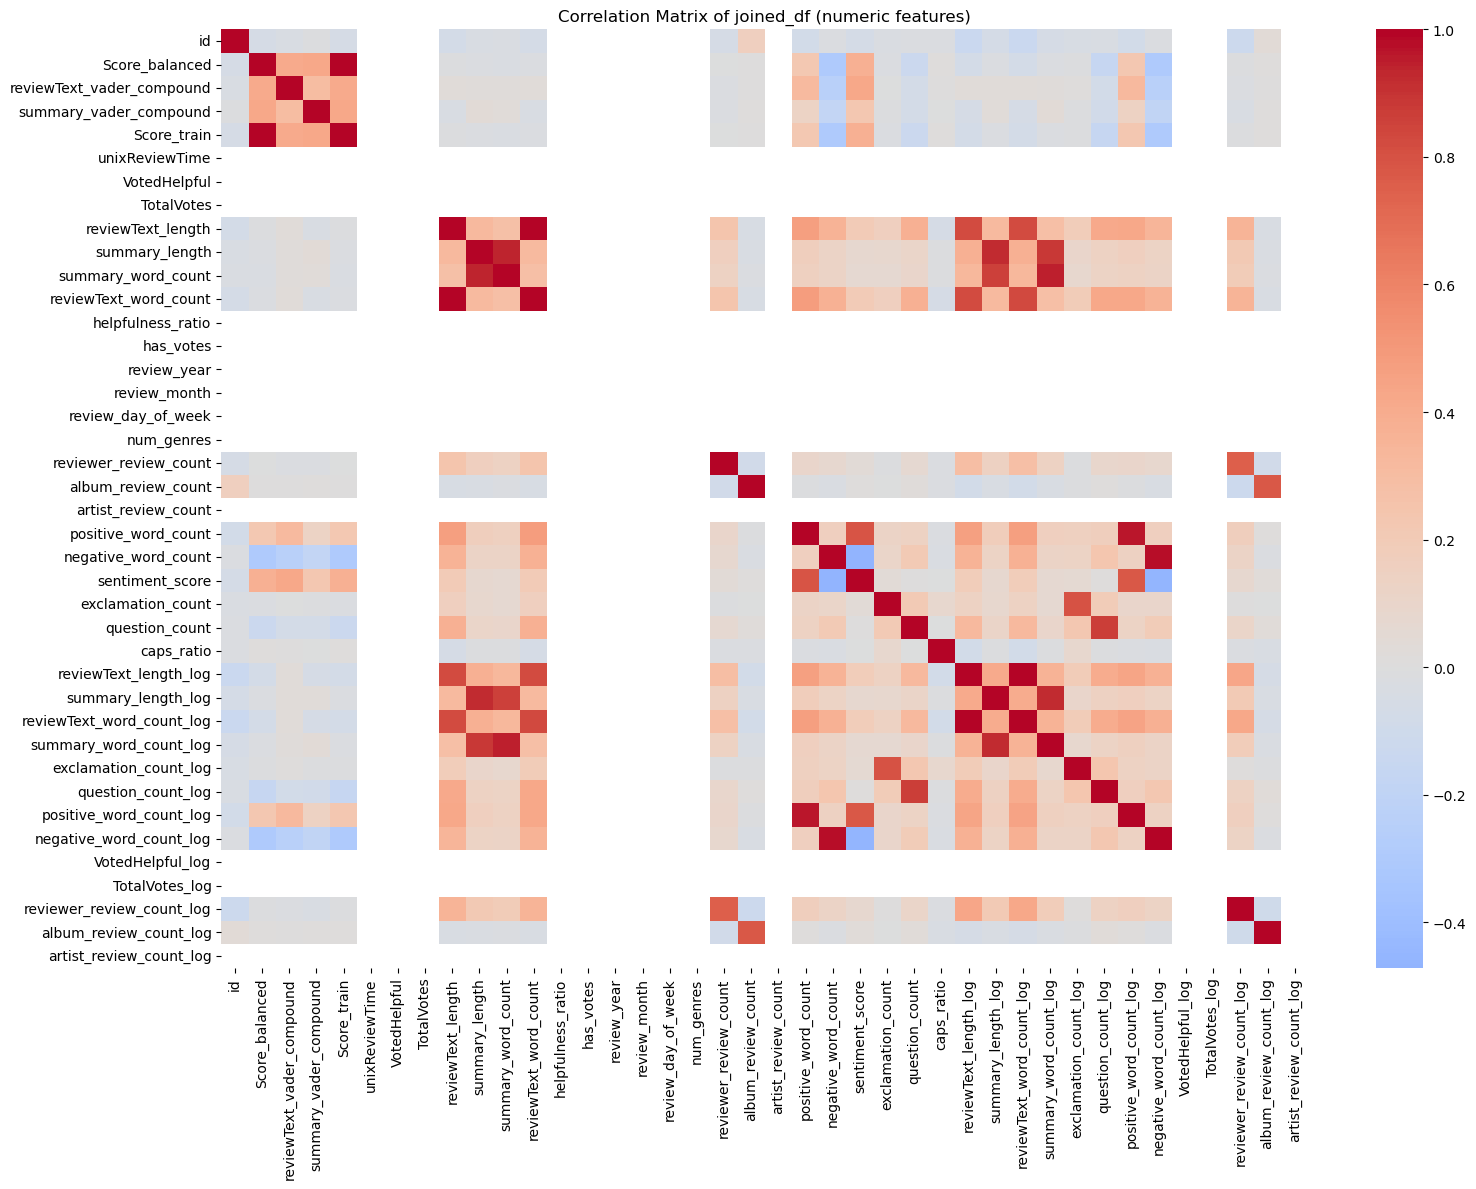

In [49]:
import seaborn as sns

import matplotlib.pyplot as plt

# Compute correlation matrix for numeric columns in joined_df
numeric_cols = joined_df.select_dtypes(include=['number']).columns
corr_matrix = joined_df[numeric_cols].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation Matrix of joined_df (numeric features)")
plt.tight_layout()
plt.show()

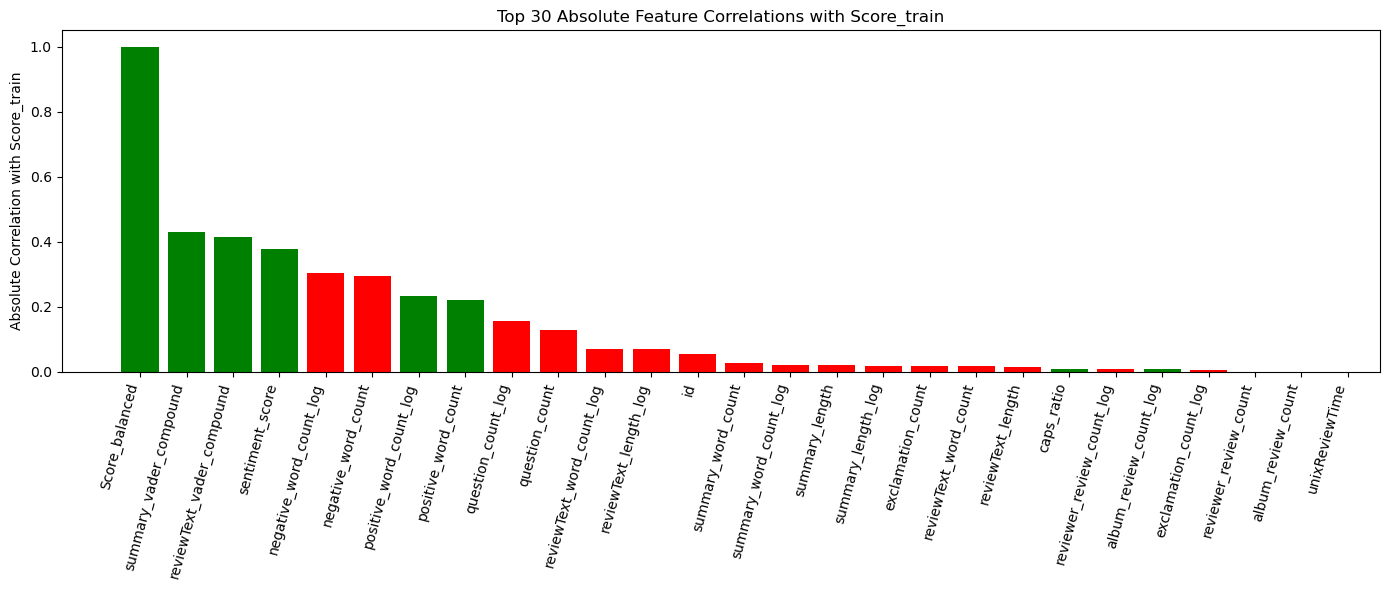

In [53]:
import matplotlib.pyplot as plt

# Compute correlations with 'Score_train' for all numeric columns
corrs = joined_df.select_dtypes(include=['number']).corr()['Score_train'].drop('Score_train')

# Get top 30 absolute correlations
top_corrs = corrs.abs().sort_values(ascending=False).head(30)
top_corrs_names = top_corrs.index

# Get original correlations for coloring
orig_corrs = corrs[top_corrs_names]
colors = ['green' if v >= 0 else 'red' for v in orig_corrs]

plt.figure(figsize=(14, 6))
plt.bar(top_corrs_names, top_corrs, color=colors)
plt.xticks(rotation=75, ha='right')
plt.ylabel("Absolute Correlation with Score_train")
plt.title("Top 30 Absolute Feature Correlations with Score_train")
plt.tight_layout()
plt.show()

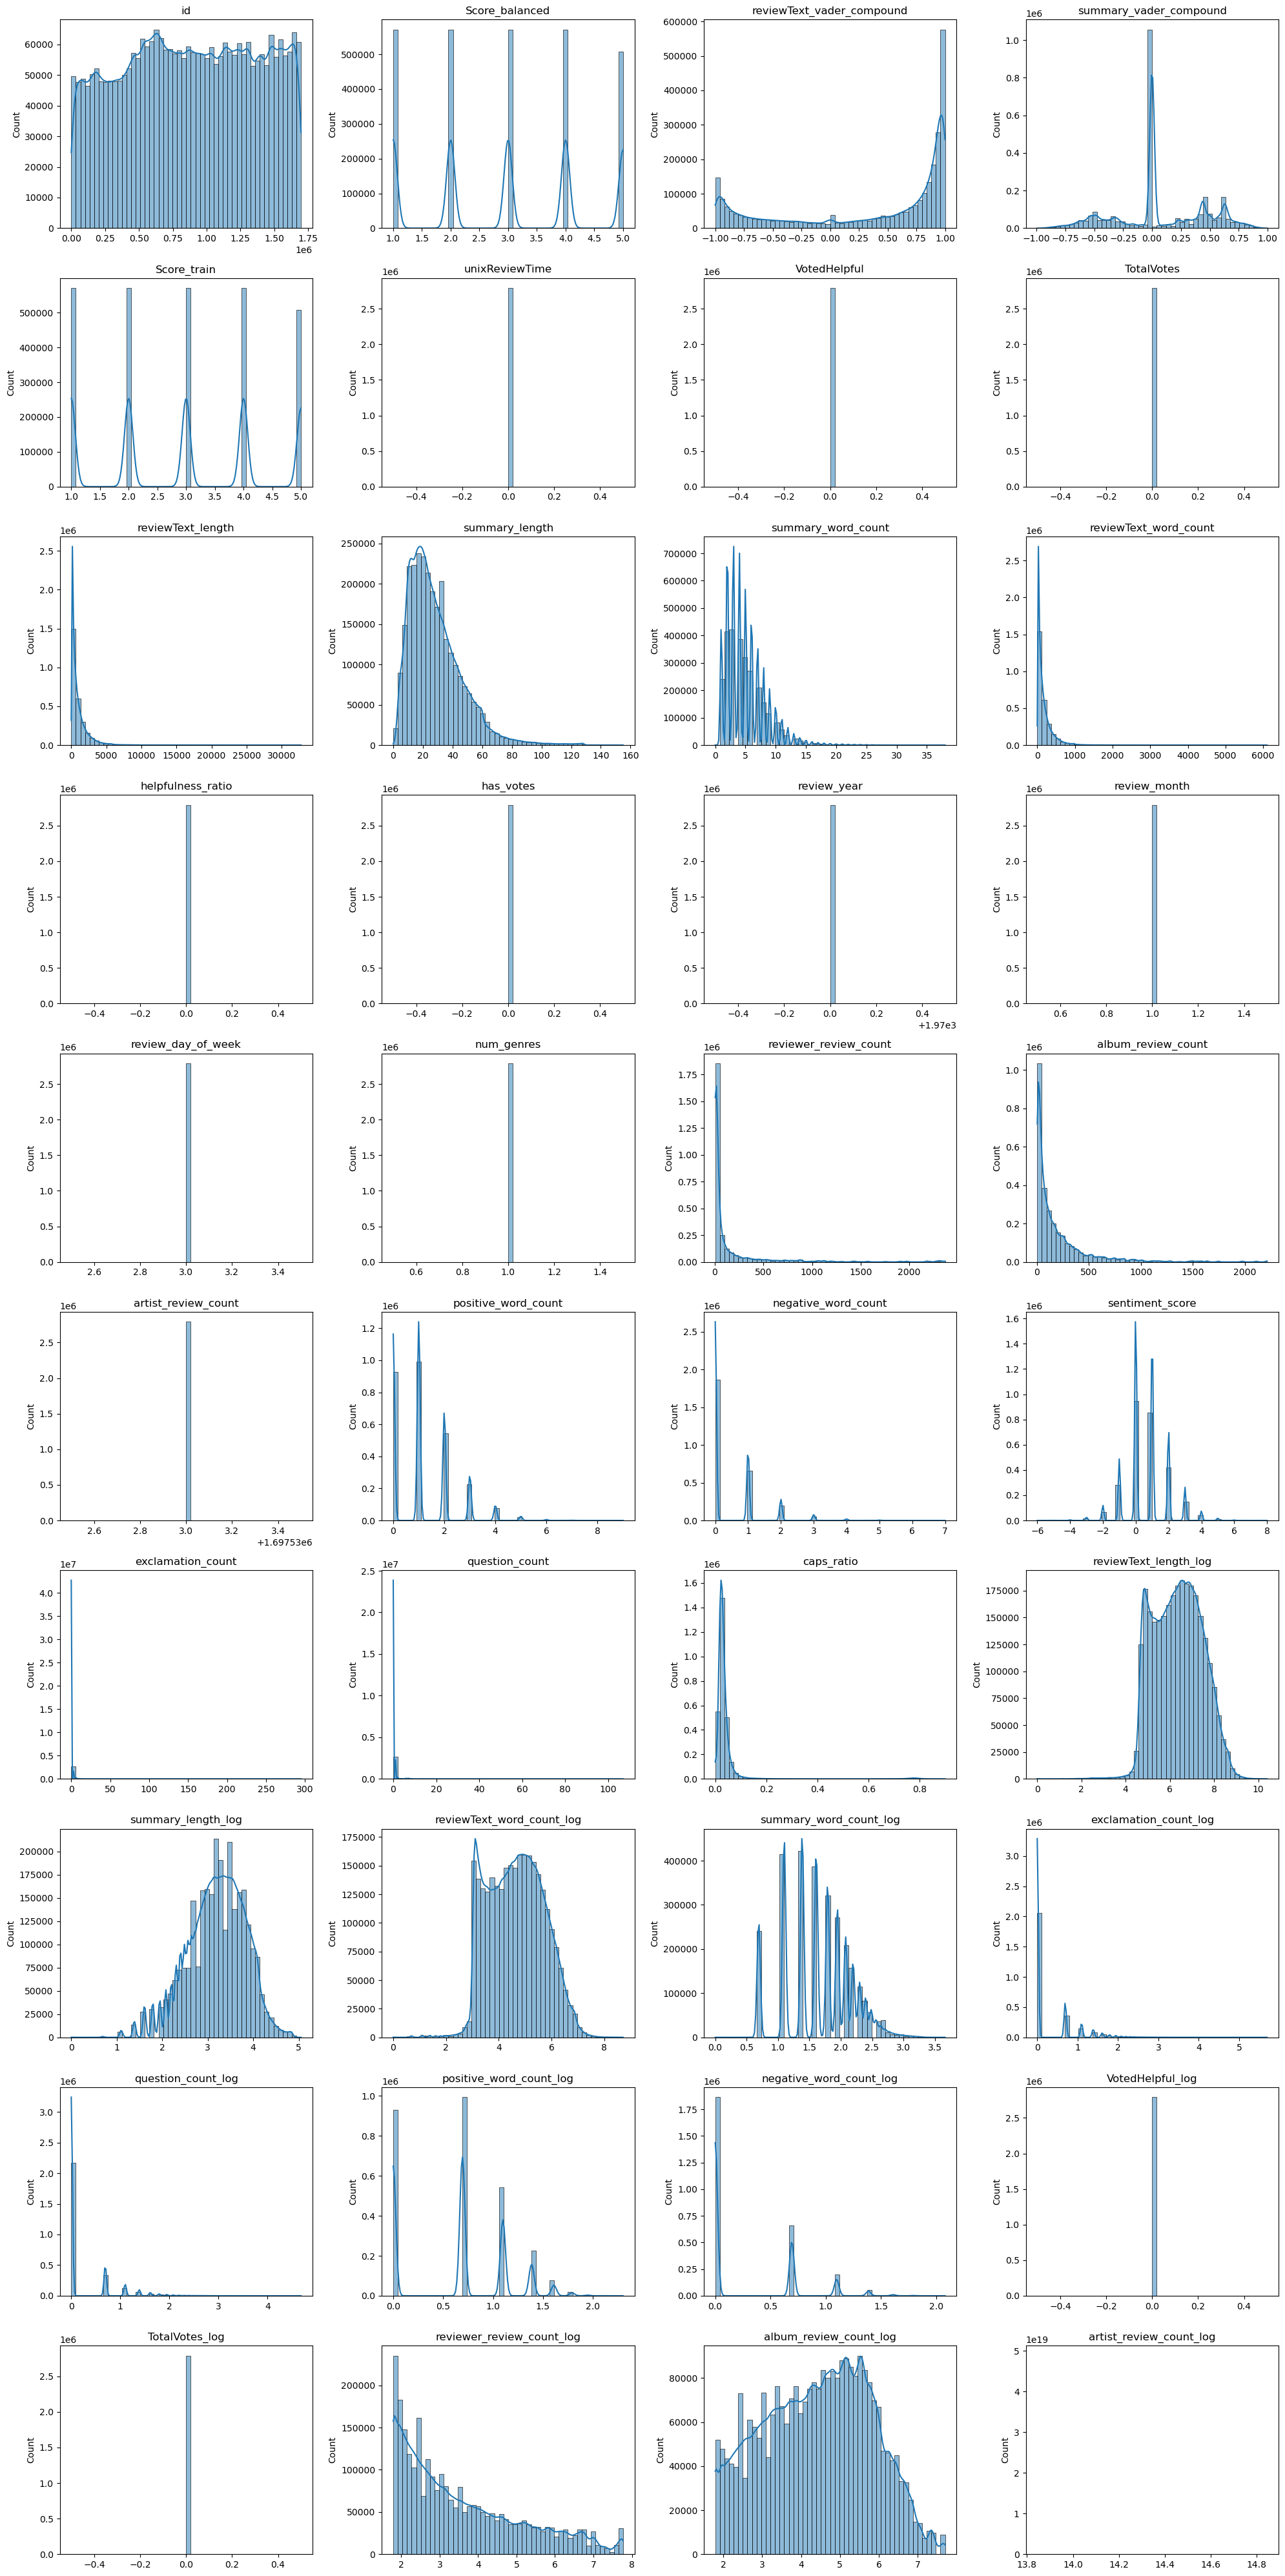

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric columns for distribution plots
numeric_cols = joined_df.select_dtypes(include=['number']).columns

n_cols = 4
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    sns.histplot(joined_df[col].dropna(), bins=50, kde=True, ax=ax)
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('Count')

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

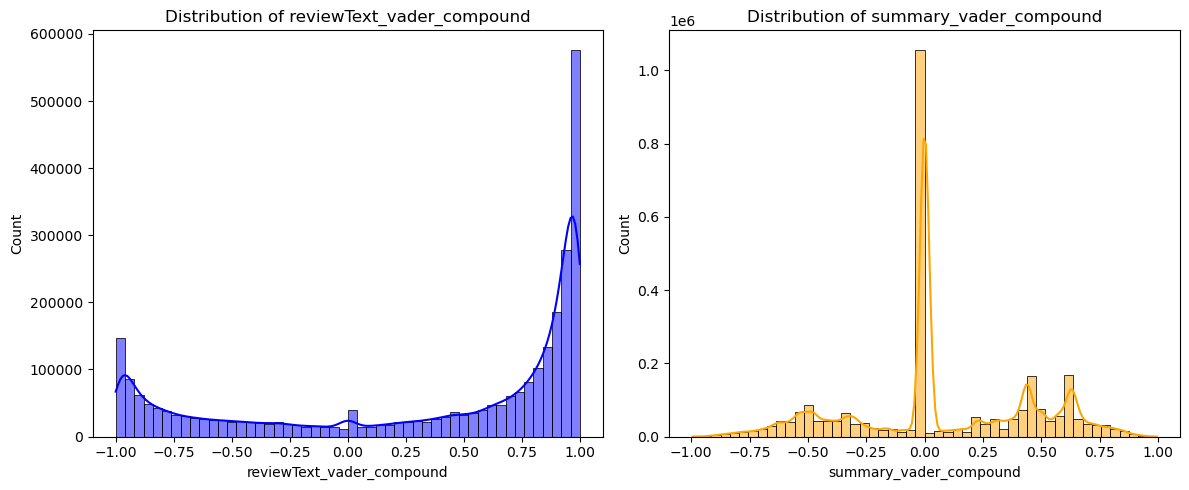

In [55]:
import seaborn as sns

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(joined_df['reviewText_vader_compound'].dropna(), bins=50, kde=True, color='blue')
plt.title('Distribution of reviewText_vader_compound')
plt.xlabel('reviewText_vader_compound')

plt.subplot(1, 2, 2)
sns.histplot(joined_df['summary_vader_compound'].dropna(), bins=50, kde=True, color='orange')
plt.title('Distribution of summary_vader_compound')
plt.xlabel('summary_vader_compound')

plt.tight_layout()
plt.show()


In [ ]:
# ================================================================
# Build clean training table + Train + (optional) Predict
# ================================================================
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# --------------------------
# Config
# --------------------------
TEXT_COL = 'text_merged'
TARGET_COL = 'Score_train'
ENGINEERED_FEATURES = [
    'summary_vader_compound',      # from train_balanced
    'reviewText_vader_compound',   # from train_balanced
    'sentiment_score',             # from train_df
    'negative_word_count_log',     # from train_df
    'positive_word_count_log',     # from train_df
    'question_count_log',          # from train_df
    'exclamation_count_log'        # from train_df
]

# TF-IDF + LR (good defaults)
TFIDF_PARAMS = dict(
    max_features=100_000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.95,
    lowercase=True,
    strip_accents='unicode',
    sublinear_tf=True,
    norm='l2',
    dtype=np.float32
)
LR_PARAMS = dict(
    penalty='l2',
    C=2.0,
    max_iter=1000,
    solver='lbfgs',
    n_jobs=-1,
    class_weight='balanced',
    multi_class='auto'
)

TEST_SIZE = 0.2
RANDOM_STATE = 42
SUBSAMPLE_FRACTION = 0.1      # e.g., 0.1 for quick tune; None for full
REQUIRE_TEXT_FOR_ALL = False     # True = assert text for all 1,697,533; False = train on available text subset

# --------------------------
# Helpers
# --------------------------
def detect_id(df: pd.DataFrame):
    if 'Id' in df.columns: return 'Id'
    if 'id' in df.columns: return 'id'
    return None

def build_text_map_from_pairs(df: pd.DataFrame, id_col: str, text_pairs: list[tuple[str,str]]):
    """
    Try a list of (reviewText_col, summary_col) candidates; return [id_key, text_merged]
    using the first available pair with any non-empty result.
    """
    out = pd.DataFrame(columns=['id_key', TEXT_COL])
    if df is None or id_col is None: return out
    work = df.copy()
    work['id_key'] = pd.to_numeric(work[id_col], errors='coerce').astype('Int64')

    for rt, sm in text_pairs:
        if rt in work.columns and sm in work.columns:
            tmp = work[['id_key', rt, sm]].copy()
            tmp[TEXT_COL] = (
                tmp[[rt, sm]]
                .fillna('')
                .agg(lambda row: ' '.join([s for s in row if isinstance(s, str) and s.strip()]), axis=1)
            )
            res = tmp[['id_key', TEXT_COL]].dropna(subset=['id_key'])
            res = res[res[TEXT_COL].astype(str).str.len() > 0]
            if len(res):
                return res.drop_duplicates(subset=['id_key'])
    return out

def build_text_map_from_single(df: pd.DataFrame, id_col: str, single_cols: list[str]):
    """Fallback: use any single text-like column; return [id_key, text_merged]."""
    out = pd.DataFrame(columns=['id_key', TEXT_COL])
    if df is None or id_col is None: return out
    work = df.copy()
    work['id_key'] = pd.to_numeric(work[id_col], errors='coerce').astype('Int64')

    for col in single_cols:
        if col in work.columns:
            tmp = work[['id_key', col]].copy()
            tmp[TEXT_COL] = tmp[col].fillna('').astype(str)
            res = tmp[['id_key', TEXT_COL]].dropna(subset=['id_key'])
            res = res[res[TEXT_COL].astype(str).str.len() > 0]
            if len(res):
                return res.drop_duplicates(subset=['id_key'])
    return out

def build_numeric_features(df: pd.DataFrame, keep_cols: list[str]):
    """Return [id_key] + available engineered features from df (drop duplicates)."""
    out = pd.DataFrame(columns=['id_key'] + keep_cols)
    if df is None: return out
    id_col = detect_id(df)
    if id_col is None: return out
    work = df.copy()
    work['id_key'] = pd.to_numeric(work[id_col], errors='coerce').astype('Int64')
    cols = ['id_key'] + [c for c in keep_cols if c in work.columns]
    if len(cols) == 1:  # only id_key, nothing to bring
        return pd.DataFrame(columns=cols)
    return work[cols].dropna(subset=['id_key']).drop_duplicates(subset=['id_key'])

def build_fallback_labels(df: pd.DataFrame, df_name: str):
    """Return [Id_norm, Score_fallback] if DF has an ID and any score col among ['Score','Score_train','Score_balanced']."""
    if df is None: return None
    id_col = detect_id(df)
    if id_col is None: return None
    score_col = next((c for c in ['Score', 'Score_train', 'Score_balanced'] if c in df.columns), None)
    if score_col is None: return None
    tmp = df[[id_col, score_col]].copy()
    tmp[id_col] = pd.to_numeric(tmp[id_col], errors='coerce').astype('Int64')
    tmp[score_col] = pd.to_numeric(tmp[score_col], errors='coerce')
    tmp = tmp.dropna(subset=[id_col, score_col]).drop_duplicates(subset=[id_col])
    tmp = tmp.rename(columns={id_col: 'Id_norm', score_col: 'Score_fallback'})
    tmp['__src__'] = df_name
    return tmp

def stratified_fraction_sample(df: pd.DataFrame, target_col: str, frac: float, random_state: int = 42):
    if not (0 < frac < 1): raise ValueError("frac must be in (0,1)")
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=1 - frac, random_state=random_state)
    y = df[target_col]
    for keep_idx, _ in splitter.split(df, y):
        return df.iloc[keep_idx].copy()

# --------------------------
# 0) Ensure inputs exist / load test_df if needed
# --------------------------
if 'train_df' not in globals():
    raise NameError("train_df is not defined. Load it into the environment first.")
if 'train_balanced' not in globals():
    raise NameError("train_balanced is not defined. Load it into the environment first.")

if 'test_df' not in globals():
    try:
        test_df = pd.read_csv("test.csv", low_memory=False)
    except FileNotFoundError:
        test_df = None
        print("NOTE: test.csv not found and test_df not defined. Skipping prediction part.")

# --------------------------
# 1) Canonical labels (LEFT)
# --------------------------
labels_raw = pd.read_csv("train.csv", low_memory=False)
ID_CANON = detect_id(labels_raw)
if ID_CANON is None or 'Score' not in labels_raw.columns:
    raise KeyError("train.csv must contain 'Id' (or 'id') and 'Score'.")

labels_raw = labels_raw.copy()
labels_raw[ID_CANON] = pd.to_numeric(labels_raw[ID_CANON], errors='coerce').astype('Int64')
labels_raw['Score'] = pd.to_numeric(labels_raw['Score'], errors='coerce').astype('Int64')

labels = (labels_raw[[ID_CANON, 'Score']]
          .dropna(subset=[ID_CANON])
          .drop_duplicates(subset=[ID_CANON])
          .rename(columns={ID_CANON: 'Id_norm', 'Score': 'Score_train'}))

EXPECTED_TOTAL = labels['Id_norm'].nunique()
print("Canonical unique IDs:", EXPECTED_TOTAL)

# --------------------------
# 2) TEXT: build maps from both sources (robust)
# --------------------------
# From train_df: use *_train pair
id_tdf = detect_id(train_df)
text_map_tdf = build_text_map_from_pairs(
    train_df, id_tdf,
    text_pairs=[('reviewText_train','summary_train')]  # you have these
)
# Fallback singles for train_df (just in case)
if len(text_map_tdf) == 0:
    text_map_tdf = build_text_map_from_single(
        train_df, id_tdf,
        single_cols=['text_merged','text_all','reviewText_train','summary_train']
    )

# From train_balanced: use unsuffixed pair
id_tbal = detect_id(train_balanced)
text_map_tbal = build_text_map_from_pairs(
    train_balanced, id_tbal,
    text_pairs=[('reviewText','summary')]
)
# Fallback singles for train_balanced
if len(text_map_tbal) == 0:
    text_map_tbal = build_text_map_from_single(
        train_balanced, id_tbal,
        single_cols=['text_merged','text_all','reviewText','summary']
    )

# UNION text (outer), prefer train_df text when both exist
if len(text_map_tdf) and len(text_map_tbal):
    text_map = text_map_tdf.merge(text_map_tbal, how='outer', on='id_key', suffixes=('_tdf','_tbal'))
    # Coalesce
    if TEXT_COL + '_tdf' in text_map.columns and TEXT_COL + '_tbal' in text_map.columns:
        text_map[TEXT_COL] = text_map[TEXT_COL + '_tdf'].where(
            text_map[TEXT_COL + '_tdf'].notna() & (text_map[TEXT_COL + '_tdf'].astype(str).str.len() > 0),
            text_map[TEXT_COL + '_tbal']
        )
        text_map = text_map[['id_key', TEXT_COL]]
else:
    text_map = pd.concat([text_map_tdf, text_map_tbal], ignore_index=True)
    text_map = text_map.drop_duplicates(subset=['id_key'])

print("Text map rows (unique ids with text):", text_map['id_key'].nunique())

# --------------------------
# 3) NUMERICS: build from both sources
# --------------------------
# From train_df: sentiment/log-count features
numeric_from_tdf = build_numeric_features(
    train_df,
    keep_cols=['sentiment_score',
               'negative_word_count_log','positive_word_count_log',
               'question_count_log','exclamation_count_log']
)
# From train_balanced: VADER features
numeric_from_tbal = build_numeric_features(
    train_balanced,
    keep_cols=['reviewText_vader_compound','summary_vader_compound']
)

# UNION numerics (outer)
if len(numeric_from_tdf) and len(numeric_from_tbal):
    numerics = numeric_from_tdf.merge(numeric_from_tbal, how='outer', on='id_key', suffixes=('', ''))
elif len(numeric_from_tdf):
    numerics = numeric_from_tdf.copy()
else:
    numerics = numeric_from_tbal.copy()

# --------------------------
# 4) FEATURES = OUTER UNION of numerics and text (CRITICAL FIX)
# --------------------------
# Use outer join so we keep ALL ids that have EITHER numerics OR text
features_src = numerics.merge(text_map, how='outer', on='id_key')
print("Feature source rows:", len(features_src), "| Unique ids:", features_src['id_key'].nunique())

# --------------------------
# 5) Labels (LEFT) join features (RIGHT)
# --------------------------
full_train = labels.merge(
    features_src, how='left',
    left_on='Id_norm', right_on='id_key',
    validate='1:1', indicator=True
)
print("\nMerge indicator (labels LEFT -> features):")
print(full_train['_merge'].value_counts(dropna=False))
full_train.drop(columns=['_merge','id_key'], inplace=True)

# --------------------------
# 6) Repair labels if train.csv had NaNs (fallback from available sources)
# --------------------------
fallback_frames = []
fb_train_df = build_fallback_labels(train_df, 'train_df')
fb_balanced = build_fallback_labels(train_balanced, 'train_balanced')
if fb_train_df is not None: fallback_frames.append(fb_train_df)
if fb_balanced is not None: fallback_frames.append(fb_balanced)

if fallback_frames:
    order = {'train_df': 0, 'train_balanced': 1}
    fb = pd.concat(fallback_frames, ignore_index=True)
    fb['__ord__'] = fb['__src__'].map(order).fillna(99)
    fb = fb.sort_values(['__ord__']).drop_duplicates(subset=['Id_norm'], keep='first')
    fb = fb.drop(columns=['__ord__', '__src__'])

    full_train = full_train.merge(fb, how='left', on='Id_norm', validate='1:1')
    full_train['Score_train'] = pd.to_numeric(full_train['Score_train'], errors='coerce')
    full_train['Score_fallback'] = pd.to_numeric(full_train.get('Score_fallback'), errors='coerce')
    full_train['Score_train'] = full_train['Score_train'].fillna(full_train['Score_fallback'])
    full_train.drop(columns=['Score_fallback'], inplace=True, errors='ignore')

# Cast labels to Int64 if values in 1..5
rounded = full_train['Score_train'].round()
if rounded.dropna().isin([1,2,3,4,5]).all():
    full_train['Score_train'] = rounded.astype('Int64')

# --------------------------
# 7) Ensure text & numerics, with choice to require all-text or filter to available
# --------------------------
missing_text = full_train[TEXT_COL].isna().sum()
if REQUIRE_TEXT_FOR_ALL:
    if missing_text:
        raise ValueError(
            f"{missing_text:,} rows missing '{TEXT_COL}'. "
            "Provide a canonical text source covering all Ids (e.g., original train with reviewText+summary)."
        )
else:
    if missing_text:
        print(f"NOTE: {missing_text:,} rows missing '{TEXT_COL}'. "
              f"Proceeding by filtering to rows with available text.")
        full_train = full_train[full_train[TEXT_COL].notna() & (full_train[TEXT_COL].astype(str).str.len() > 0)].copy()

# Fill numeric engineered features with zeros where missing
for feat in ENGINEERED_FEATURES:
    if feat not in full_train.columns:
        full_train[feat] = 0.0
    else:
        full_train[feat] = pd.to_numeric(full_train[feat], errors='coerce').fillna(0.0)

# Final checks
assert full_train['Score_train'].isna().sum() == 0, "Some labels are NaN after repair."
assert full_train[TEXT_COL].notna().all(), "Some rows have missing text_merged after filtering."

print("\n✅ Built training frame.")
print("Final rows for training:", len(full_train))
print(full_train['Score_train'].value_counts().sort_index())

# Use as modeling frame
joined_df = full_train

# ================================================================
# MODELING: TF-IDF + engineered features + Logistic Regression
# ================================================================
# Optional subsample for speed (tuning)
if SUBSAMPLE_FRACTION is not None:
    joined_df = stratified_fraction_sample(joined_df, TARGET_COL, SUBSAMPLE_FRACTION, random_state=RANDOM_STATE)
    print(f"\nApplied stratified subsample: {SUBSAMPLE_FRACTION:.2f} -> rows: {len(joined_df):,}")

# Build X, y
X = joined_df[[TEXT_COL] + ENGINEERED_FEATURES].copy()
y = joined_df[TARGET_COL]

# Train/valid split (stratified)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# Preprocess + model
preprocess = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(**TFIDF_PARAMS), TEXT_COL),
        ('num', MaxAbsScaler(), ENGINEERED_FEATURES),
    ],
    remainder='drop',
    sparse_threshold=1.0
)
pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('clf', LogisticRegression(**LR_PARAMS))
])

# Train
pipe.fit(X_train, y_train)

# Evaluate
preds = pipe.predict(X_valid)
print("\nClassification Report:\n")
print(classification_report(y_valid, preds))
print("\nConfusion Matrix:")
print(confusion_matrix(y_valid, preds))

# ----------------------------------------------------
# Inspect top features
# ----------------------------------------------------
def extract_feature_names_and_coefs(fitted_pipeline: Pipeline):
    ct: ColumnTransformer = fitted_pipeline.named_steps['preprocess']
    clf: LogisticRegression = fitted_pipeline.named_steps['clf']
    tfidf: TfidfVectorizer = ct.named_transformers_['tfidf']
    tfidf_names = tfidf.get_feature_names_out()
    num_names = np.array(ENGINEERED_FEATURES)
    all_feature_names = np.concatenate([tfidf_names, num_names])
    coefs = clf.coef_
    classes_ = clf.classes_
    return all_feature_names, coefs, classes_
def top_features_by_class(feature_names, coefs, classes, k=15):
    coef_matrix = coefs if coefs.ndim > 1 else coefs.reshape(1, -1)
    for i, cls in enumerate(classes):
        coef = coef_matrix[i]
        top_pos_idx = np.argsort(coef)[-k:][::-1]
        top_neg_idx = np.argsort(coef)[:k]
        print(f"\nTop + features for class '{cls}':")
        for idx in top_pos_idx:
            print(f"{feature_names[idx]:<35}  {coef[idx]: .4f}")
        print(f"\nTop - features for class '{cls}':")
        for idx in top_neg_idx:
            print(f"{feature_names[idx]:<35}  {coef[idx]: .4f}")
all_feature_names, coefs, classes_ = extract_feature_names_and_coefs(pipe)
top_features_by_class(all_feature_names, coefs, classes_, k=15)

# ================================================================
# PREDICT ON TEST (optional; requires text for test Ids)
# ================================================================
if 'test_df' in globals() and test_df is not None:
    # Build a test feature map by reusing the same UNION features (numerics + text)
    test_id_col = detect_id(test_df)
    if test_id_col is None:
        raise KeyError("test_df must have 'Id' or 'id'.")
    test_df = test_df.copy()
    test_df['Id_norm'] = pd.to_numeric(test_df[test_id_col], errors='coerce').astype('Int64')
    test_df['row_ix'] = np.arange(len(test_df))

    # Rebuild features_src for test: use the same features_src we built and rename key
    feats_for_test = features_src.drop_duplicates(subset=['id_key']).rename(columns={'id_key':'Id_norm'})
    test_ready = test_df.merge(feats_for_test, how='left', on='Id_norm', validate='m:1', indicator=True)
    print("\nTEST merge indicator (test_df LEFT -> features_src):")
    print(test_ready['_merge'].value_counts(dropna=False))
    test_ready.drop(columns=['_merge'], inplace=True)

    # Ensure required columns
    if TEXT_COL not in test_ready.columns:
        test_ready[TEXT_COL] = ""
    test_ready[TEXT_COL] = test_ready[TEXT_COL].fillna('').astype(str)
    for feat in ENGINEERED_FEATURES:
        if feat not in test_ready.columns:
            test_ready[feat] = 0.0
        else:
            test_ready[feat] = pd.to_numeric(test_ready[feat], errors='coerce').fillna(0.0)

    req_cols = [TEXT_COL] + ENGINEERED_FEATURES
    missing_cols = [c for c in req_cols if c not in test_ready.columns]
    if missing_cols:
        raise KeyError(f"test_ready missing required columns: {missing_cols}")

    test_ready = test_ready.sort_values('row_ix')
    test_preds = pipe.predict(test_ready[req_cols])

    out = test_ready[['Id_norm']].copy()
    out['Score'] = test_preds
    out.rename(columns={'Id_norm': 'Id'}, inplace=True)
    out.to_csv("test2.csv", index=False)
    print("✅ Saved predictions to test2.csv")
else:
    print("\nNOTE: test_df not available; skipped prediction step.")


Canonical unique IDs: 1697533
Text map rows (unique ids with text): 1027077
Feature source rows: 1027077 | Unique ids: 1027077

Merge indicator (labels LEFT -> features):
_merge
both          1027077
left_only      670456
right_only          0
Name: count, dtype: int64
NOTE: 670,456 rows missing 'text_merged'. Proceeding by filtering to rows with available text.

✅ Built training frame.
Final rows for training: 1027077
Score_train
1     72920
2     71716
3    138449
4    236368
5    507624
Name: count, dtype: Int64

Applied stratified subsample: 0.01 -> rows: 10,270


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

         1.0       0.48      0.60      0.53       146
         2.0       0.32      0.34      0.33       143
         3.0       0.40      0.38      0.39       277
         4.0       0.42      0.41      0.42       473
         5.0       0.78      0.76      0.77      1015

    accuracy                           0.59      2054
   macro avg       0.48      0.50      0.49      2054
weighted avg       0.59      0.59      0.59      2054


Confusion Matrix:
[[ 87  25  13  10  11]
 [ 37  49  39  10   8]
 [ 21  39 105  77  35]
 [ 15  21  74 196 167]
 [ 21  20  29 174 771]]

Top + features for class '1.0':
waste                                 4.0441
money                                 3.1203
boring                                2.6988
worst                                 2.4282
the only                              2.1045
save your                             2.0555
minutes                               2.0395
not

## HYPERPARAMETER SCHEDULER

Applied stratified subsample: 0.01 -> rows: 27,919


Scheduling C: 100%|██████████| 6/6 [01:32<00:00, 15.47s/it]


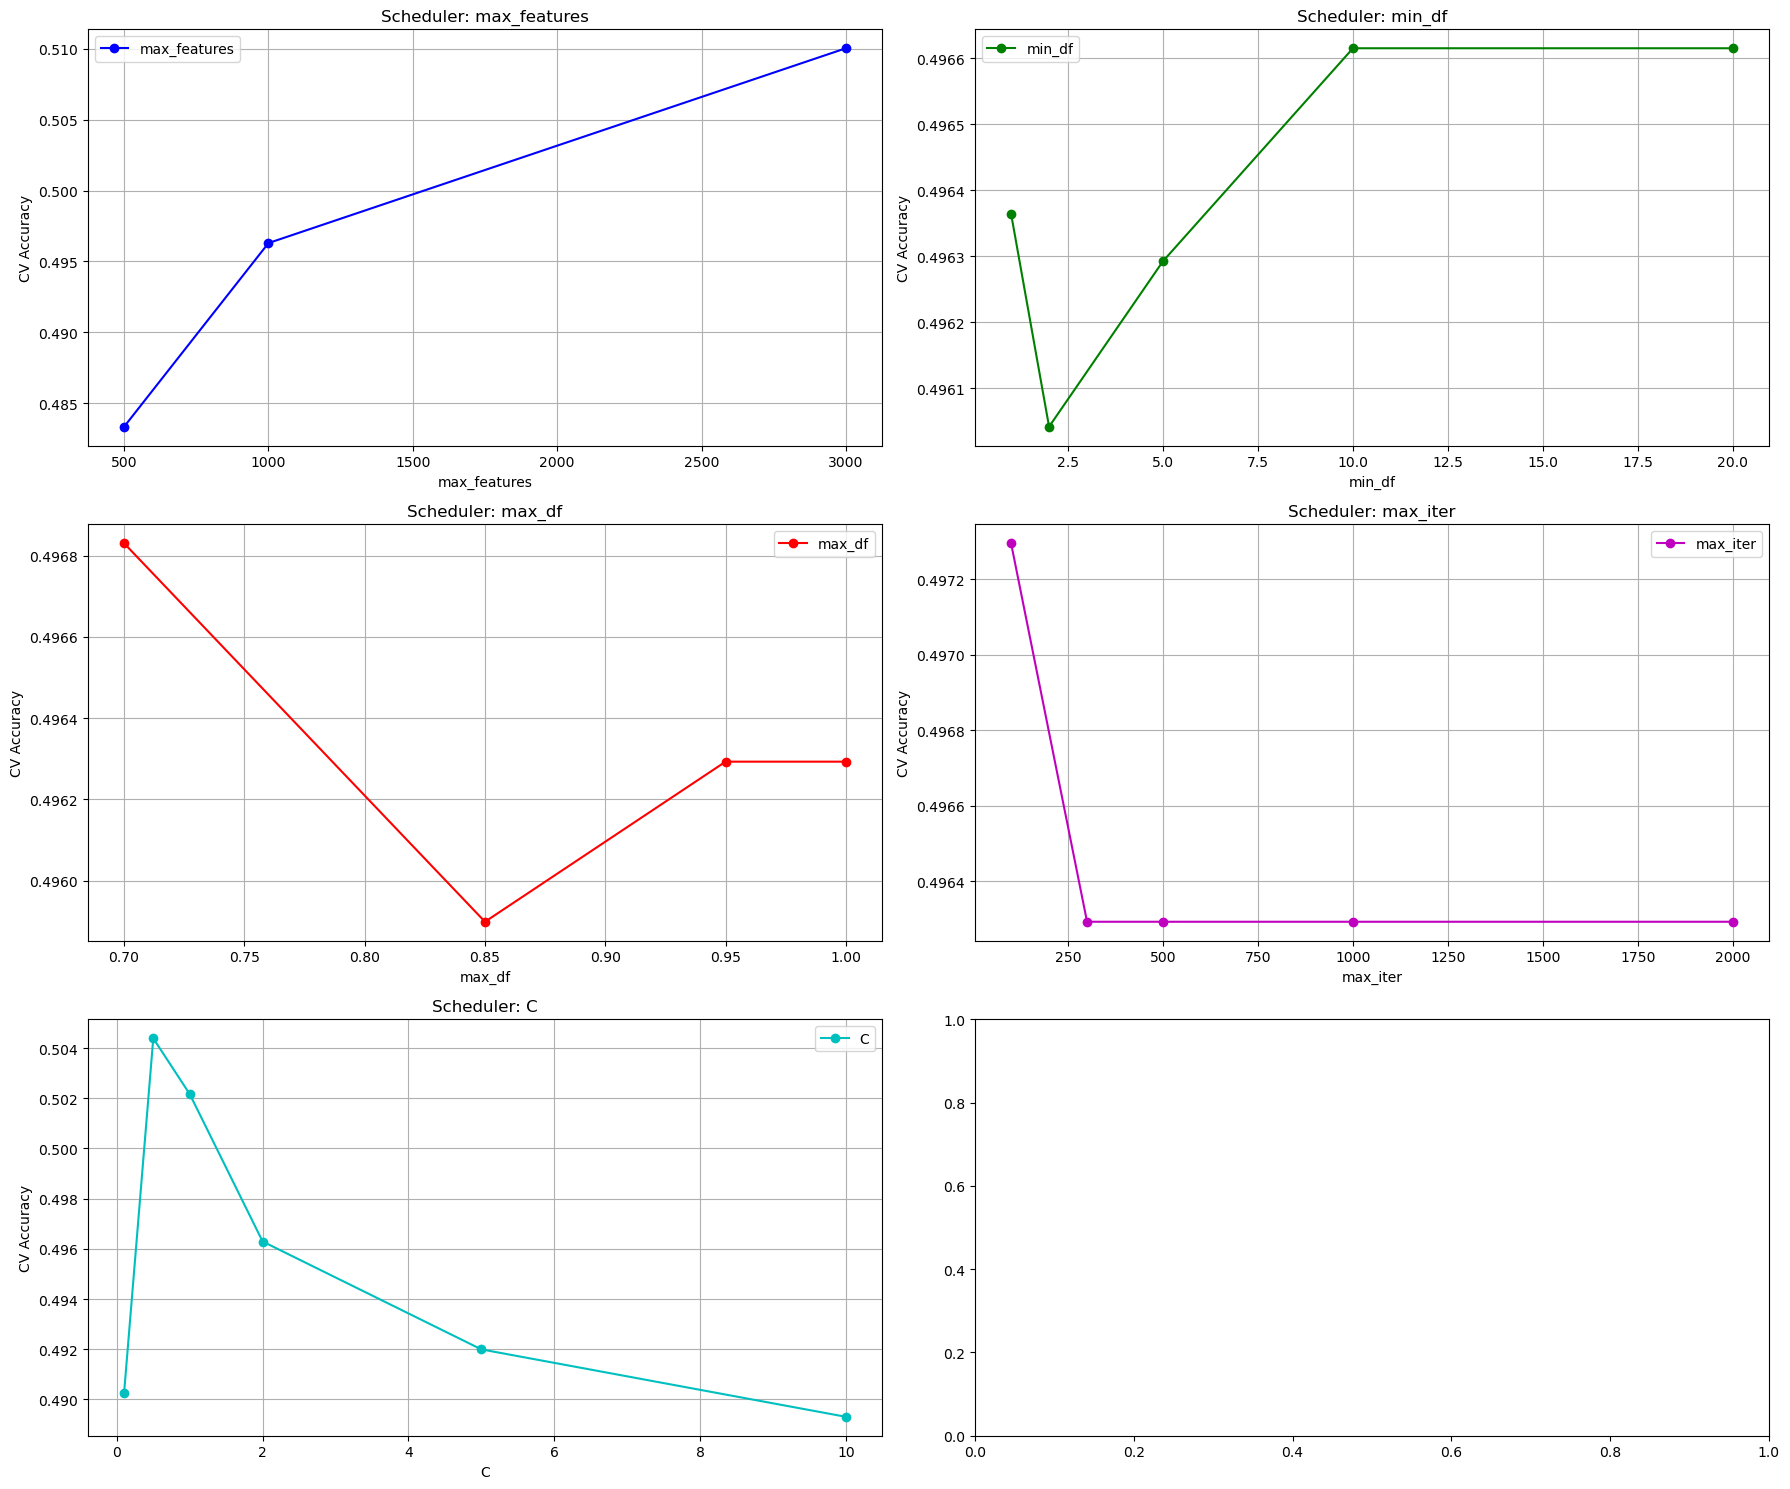

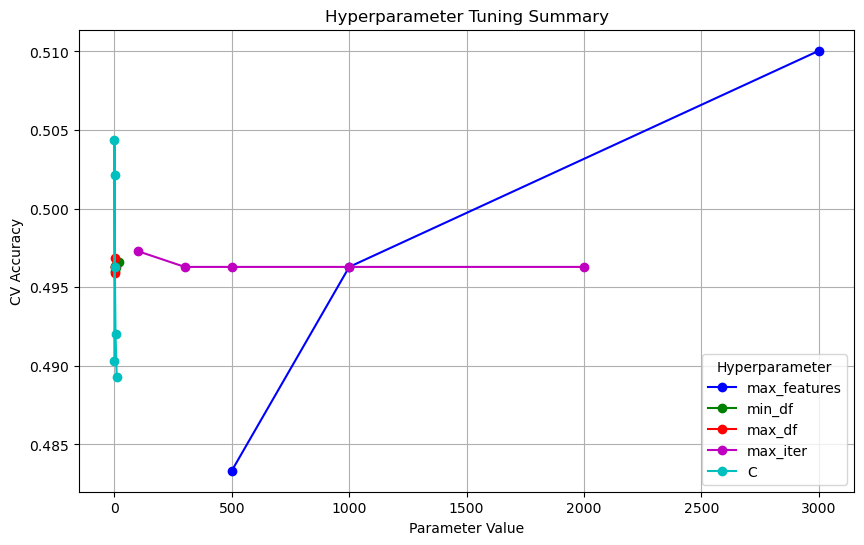

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MaxAbsScaler
from tqdm import tqdm

# --- Use your actual data ---
# joined_df, ENGINEERED_FEATURES, TEXT_COL, TARGET_COL should be defined above

# Stratified subsample for speed (10% of data, preserves class balance)
SUBSAMPLE_FRACTION = 0.01
RANDOM_STATE = 42

def stratified_fraction_sample(df, target_col, frac, random_state=42):
    if not (0 < frac < 1):
        raise ValueError("frac must be in (0,1)")
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=1-frac, random_state=random_state)
    y = df[target_col]
    for keep_idx, _ in splitter.split(df, y):
        return df.iloc[keep_idx].copy()

# Apply subsample to joined_df
joined_df_sub = stratified_fraction_sample(joined_df, TARGET_COL, SUBSAMPLE_FRACTION, random_state=RANDOM_STATE)
print(f"Applied stratified subsample: {SUBSAMPLE_FRACTION:.2f} -> rows: {len(joined_df_sub):,}")

# Robustly create 'text_merged' from available columns
if TEXT_COL not in joined_df_sub.columns:
    text_candidates = [
        ('summary_train', 'reviewText_train'),
        ('summary_balanced', 'reviewText_balanced'),
        ('summary', 'reviewText'),
    ]
    for summary_col, review_col in text_candidates:
        if summary_col in joined_df_sub.columns and review_col in joined_df_sub.columns:
            joined_df_sub[TEXT_COL] = joined_df_sub[summary_col].astype(str) + " " + joined_df_sub[review_col].astype(str)
            break
    else:
        raise ValueError(
            f"Cannot create '{TEXT_COL}': no valid summary/reviewText column pair found in joined_df_sub.\n"
            f"Available columns: {list(joined_df_sub.columns)}"
        )

# Build X, y for scheduler (robust check)
req_cols = [TEXT_COL] + ENGINEERED_FEATURES
missing = [c for c in req_cols if c not in joined_df_sub.columns]
if missing:
    raise ValueError(f"Missing columns in joined_df_sub: {missing}")
X = joined_df_sub[req_cols].copy()
y = joined_df_sub[TARGET_COL]

# Parameter grids (add C for LogisticRegression)
param_schedules = {
    'max_features': [500, 1000, 3000],
    'min_df': [1, 2, 5, 10, 20],
    'max_df': [0.7, 0.85, 0.95, 1.0],
    'max_iter': [100, 300, 500, 1000, 2000],
    'C': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
}

# Default params
TFIDF_PARAMS = dict(
    max_features=1000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.95,
    lowercase=True,
    strip_accents='unicode',
    sublinear_tf=True,
    norm='l2',
    dtype=np.float32
)
LR_PARAMS = dict(
    penalty='l2',
    C=2.0,
    max_iter=1000,
    solver='lbfgs',
    n_jobs=-1,
    class_weight='balanced',
    multi_class='auto'
)

def make_pipe(tfidf_params, lr_params):
    preprocess = ColumnTransformer(
        transformers=[
            ('tfidf', TfidfVectorizer(**tfidf_params), TEXT_COL),
            ('num', MaxAbsScaler(), ENGINEERED_FEATURES),
        ],
        remainder='drop',
        sparse_threshold=1.0
    )
    pipe = Pipeline([
        ('preprocess', preprocess),
        ('clf', LogisticRegression(**lr_params))
    ])
    return pipe

def run_scheduler(param_name, values, tfidf_params, lr_params, X, y, cv=3):
    scores = []
    for v in tqdm(values, desc=f"Scheduling {param_name}"):
        tfidf_params_ = tfidf_params.copy()
        lr_params_ = lr_params.copy()
        if param_name in TFIDF_PARAMS:
            tfidf_params_[param_name] = v
        else:
            lr_params_[param_name] = v
        pipe = make_pipe(tfidf_params_, lr_params_)
        score = cross_val_score(pipe, X, y, cv=cv, scoring='accuracy', n_jobs=-1).mean()
        scores.append(score)
    return values, scores

# Run all schedulers and plot
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
axes = axes.flatten()
colors = ['b', 'g', 'r', 'm', 'c', 'y']
results = {}

for i, (param, values) in enumerate(param_schedules.items()):
    vals, scores = run_scheduler(param, values, TFIDF_PARAMS, LR_PARAMS, X, y, cv=3)
    axes[i].plot(vals, scores, marker='o', color=colors[i], label=param)
    axes[i].set_title(f"Scheduler: {param}")
    axes[i].set_xlabel(param)
    axes[i].set_ylabel("CV Accuracy")
    axes[i].grid(True)
    axes[i].legend()
    results[param] = (vals, scores)

plt.tight_layout()
plt.show()

# Summary overlay plot
plt.figure(figsize=(10, 6))
for i, (param, (vals, scores)) in enumerate(results.items()):
    plt.plot(vals, scores, marker='o', color=colors[i], label=param)
plt.title("Hyperparameter Tuning Summary")
plt.xlabel("Parameter Value")
plt.ylabel("CV Accuracy")
plt.grid(True)
plt.legend(title="Hyperparameter")
plt.show()

In [66]:
print(joined_df.columns)

Index(['id', 'album_mbid_balanced', 'reviewerID_balanced', 'summary_balanced',
       'reviewText_balanced', 'Score_balanced', 'reviewText_vader_compound',
       'summary_vader_compound', 'album_mbid_train', 'reviewerID_train',
       'summary_train', 'reviewText_train', 'Score_train', 'genres',
       'artist_mbid', 'unixReviewTime', 'VotedHelpful', 'TotalVotes',
       'reviewText_length', 'summary_length', 'summary_word_count',
       'reviewText_word_count', 'helpfulness_ratio', 'has_votes',
       'review_date', 'review_year', 'review_month', 'review_day_of_week',
       'num_genres', 'reviewer_review_count', 'album_review_count',
       'artist_review_count', 'reviewText_lower', 'positive_word_count',
       'negative_word_count', 'sentiment_score', 'exclamation_count',
       'question_count', 'caps_ratio', 'reviewText_length_log',
       'summary_length_log', 'reviewText_word_count_log',
       'summary_word_count_log', 'exclamation_count_log', 'question_count_log',
       'po